In [1]:
# запускаем в colab или локально?
try:
    from google.colab import drive
    colab = True
except ImportError:
    colab = False

print(f"colab: {colab}")

colab: False


In [2]:
# установка необходимых пакетов в colab
if colab:
    !pip install rootutils -q
    !pip install torchmetrics -q
    !pip install torchinfo -q
    !pip install lightning -q

In [3]:
# монтирование google диска и установка
# рабочей директории в `computer-vision`

import os
from rootutils import setup_root

if colab:
    drive.mount("/content/drive", force_remount=True)
    os.chdir("drive/MyDrive/computer-vision")
    root = setup_root(".", indicator="homeworks", pythonpath=True)
else:
    root = setup_root(".", indicator="homeworks", pythonpath=True)

os.chdir(root)
print(f"working directory: {os.getcwd()}")


working directory: /Users/alex/computer-vision


In [4]:
# создание директории для данных

from pathlib import Path

if colab:
    DATA_DIR = Path("/content/data")
else:
    DATA_DIR = root / "data"

DATA_DIR.mkdir(exist_ok=True)

print(f"DATA_DIR: {DATA_DIR}")

DATA_DIR: /Users/alex/computer-vision/data


In [5]:
# настройка matplotlib

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format="retina"

plt.style.use("seaborn-v0_8-notebook")

In [6]:
# Load tensorboard extension
%load_ext tensorboard

## **Полносвязные нейронные сети. Методы регуляризации**

### **Полносвязные нейронные сети**

**Полносвязные нейронные сети** (Fully Connected Neural Networks, FCNN).

Другое название - **многослойный перцептрон** (Multilayer Perceptron, MLP).

**Пример полносвязной сети**

<center>
    <figure>
        <img src="figs/02/fcnn.jpg" width="600px"/>
    </figure>
</center>

- У этой сети один входной слой, один выходной слой и три скрытых слоя.

- Параметры нейронной сети 
    $$
        \mathbf{w} = \left\{
            \boldsymbol{\beta}_0,\boldsymbol{\Omega}_0,
            \boldsymbol{\beta}_1,\boldsymbol{\Omega}_1,
            \boldsymbol{\beta}_2,\boldsymbol{\Omega}_2,
            \boldsymbol{\beta}_3,\boldsymbol{\Omega}_3
        \right\}
    $$
    Число параметров равно:
    $$
        (D_1\cdot D_i + D_1) + (D_2\cdot D_1 + D_2) + (D_3\cdot D_2 + D_3) + (D_0\cdot D_3 + D_0) = 43
    $$

- Вычисления слоев нейронной сети:
    $$
        \mathbf{h}_1 = \mathbf{a}\left[\boldsymbol{\beta}_0 + \mathbf{\Omega}_0 \mathbf{x}\right]
    $$
    $$
        \mathbf{h}_2 = \mathbf{a}\left[\boldsymbol{\beta}_1 + \mathbf{\Omega}_1 \mathbf{h}_1\right]
    $$
    $$
        \mathbf{h}_3 = \mathbf{a}\left[\boldsymbol{\beta}_2 + \mathbf{\Omega}_2 \mathbf{h}_2\right]
    $$
    $$
        \mathbf{y} = \boldsymbol{\beta}_3 + \mathbf{\Omega}_3 \mathbf{h}_3
    $$

    где $\mathbf{a}$ - функция активации, обычно это $\mathrm{ReLU}$ (Rectified Linear Unit):
    <center>
        <figure>
            <img src="https://media.githubusercontent.com/media/alextanch/computer-vision/refs/heads/at/lesson2/notebooks/figs/02/relu.png" width="200px"/>
        </figure>
    </center>

    $$
        a[z] = \mathrm{ReLU}[z] =
        \begin{cases}
            0 & z < 0\\
            z & z \geqslant 0
        \end{cases}
    $$

- Сеть называется **полносвязной**, поскольку каждый элемент (node) связан со всеми предыдущими элементами.


Для создания одного слоя в PyTorch используется класс `torch.nn.Linear()`: 

In [7]:
from torch import nn

class Net(nn.Module):
    def __init__(self, Di=3, D1=4, D2=2, D3=3, Do=2):
        super().__init__()

        self.lin1 = nn.Linear(Di, D1)
        self.lin2 = nn.Linear(D1, D2)
        self.lin3 = nn.Linear(D2, D3)
        self.lin4 = nn.Linear(D3, Do)

        self.act = nn.ReLU() 
         
    def forward(self, x):
        h1 = self.act(self.lin1(x))
        h2 = self.act(self.lin2(h1))
        h3 = self.act(self.lin3(h2))
        
        y = self.lin4(h3)

        return y

Протестируем работу сети:

In [8]:
import torch

# модель сети
model = Net()

# батч размера 5 из случайных чисел
x = torch.rand((5, 3))

# forward pass
y = model(x)

print(f"x.shape: {x.shape}")
print(f"\nx: {x}")
print(f"\ny.shape: {y.shape}")
print(f"\ny: {y}")

x.shape: torch.Size([5, 3])

x: tensor([[0.2295, 0.3219, 0.3251],
        [0.1857, 0.5534, 0.8699],
        [0.6706, 0.8455, 0.4662],
        [0.6288, 0.4890, 0.5237],
        [0.0253, 0.3506, 0.1110]])

y.shape: torch.Size([5, 2])

y: tensor([[0.6786, 0.2852],
        [0.6786, 0.2852],
        [0.6786, 0.2852],
        [0.6786, 0.2852],
        [0.6786, 0.2852]], grad_fn=<AddmmBackward0>)


Выведем информацию об архитектуре сети:

In [9]:
import torchinfo

print(torchinfo.summary(model, input_size=x.shape, device="cpu"))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [5, 2]                    --
├─Linear: 1-1                            [5, 4]                    16
├─ReLU: 1-2                              [5, 4]                    --
├─Linear: 1-3                            [5, 2]                    10
├─ReLU: 1-4                              [5, 2]                    --
├─Linear: 1-5                            [5, 3]                    9
├─ReLU: 1-6                              [5, 3]                    --
├─Linear: 1-7                            [5, 2]                    8
Total params: 43
Trainable params: 43
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Можно написать более компактную реализацию с помощью `torch.nn.Sequential`:

In [10]:
class Net(nn.Module):
    def __init__(self, Di=3, D1=4, D2=2, D3=3, Do=2):
        super().__init__()

        act = nn.ReLU()

        self.layers = nn.Sequential(
            nn.Linear(Di, D1),
            act,
            nn.Linear(D1, D2),
            act,
            nn.Linear(D2, D3),
            act,
            nn.Linear(D3, Do),
        )
         
    def forward(self, x):
        y = self.layers(x)

        return y
    
    model = Net()

    print(torchinfo.summary(model, input_size=x.shape, device="cpu"))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [5, 2]                    --
├─Linear: 1-1                            [5, 4]                    16
├─ReLU: 1-2                              [5, 4]                    --
├─Linear: 1-3                            [5, 2]                    10
├─ReLU: 1-4                              [5, 2]                    --
├─Linear: 1-5                            [5, 3]                    9
├─ReLU: 1-6                              [5, 3]                    --
├─Linear: 1-7                            [5, 2]                    8
Total params: 43
Trainable params: 43
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


### **Методы регуляризации**

- **Регуляризация в математике**: добавление к функции
    потерь заданных в явном виде членов, которые приводят к определенному
    выбору параметров.

- **Регуляризация в машинном обучении**: любые методы, которые улучшают обобщающую способность модели.

Наиболее распространенные методы регуляризации:

- Выбор подходящей модели.

- Инициализация параметров модели.
- Выбор оптимизатора для обучения.
- Learning rate schedulers.
- Регуляризация функции потерь.
- Аугментация данных во время обучения.
- Ранняя остановка обучения (early stopping).

Применим некоторые из методов регуляризации на примере задачи классификации изображений. 

### **Классификация изображений Fashion-MNIST** 

На примере задачи классификации изображений из датасета Fashion-MNIST, рассмотрим использование некоторых из методов регуляризации.

Для обучения и тестирования модели классификации будем использовать фреймворк PyTorch Lightning.

#### **Данные Fasion-MNIST**

<center>
    <figure>
        <img src="https://media.githubusercontent.com/media/alextanch/computer-vision/refs/heads/at/lesson2/notebooks/figs/02/fashion_mnist.jpg" width="700px"/>
    </figure>
</center>

- Размер изображений: 28x28 пикселей

- Цветовое пространство: grayscale

- Количество классов: 10 (одежда)

- Размер набора данных: 60 000 обучающих и 10 000 тестовых изображений


In [11]:
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

В torchvision датасетах:

https://docs.pytorch.org/vision/main/datasets.html#image-classification

есть класс для работы Fashion-MNIST.

Для того чтобы попрактиковаться, напишем свою реализацию класса `torch.utils.data.Dataset` для Fashion-MNIST.

Загрузим и распакуем Fashion-MNIST данные с Google Disk:

In [12]:
from src.utils import download_and_extract

download_and_extract("1KpBql_Rpc1dtBSwFTT7UZdNLUoDde6YQ", "fashion-mnist.zip", DATA_DIR)

Done!


In [13]:
import cv2
import lightning.pytorch as pl

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms as T


class DataSet(Dataset):
    def __init__(self, image_files, transform):
        super().__init__()

        self.files = image_files
        self.labels = [int(f.parent.name) for f in self.files]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = cv2.imread(self.files[index], cv2.IMREAD_GRAYSCALE)

        x = self.transform(image)
        y = self.labels[index]

        return x, y

class DataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()

        self.batch_size = batch_size
        
        self.test_dataset = DataSet(
            list((data_dir / "test").glob("**/*.png")), 
            T.Compose([
                T.ToTensor()
            ])
        )
    
        files = list((data_dir / "train").glob("**/*.png"))

        train_files, val_files = random_split(
            files,
            [50_000, 10_000],
            generator=torch.Generator().manual_seed(42)
        )

        self.train_dataset = DataSet(
            train_files, 
            T.Compose([
                T.ToTensor()
            ])
        )

        self.val_dataset = DataSet(
            val_files, 
            T.Compose([
                T.ToTensor()
            ])
        )
    
    def train_dataloader(self):
        loader = DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=True,
            drop_last=True
        )
        return loader

    def val_dataloader(self):
        loader = DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            drop_last=False
        )
        return loader

    def test_dataloader(self):
        loader = DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            drop_last=False
        )
        return loader

    def predict_dataloader(self):
        loader = DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            drop_last=False
        )
        return loader
    

pl.seed_everything(42)


datamodule = DataModule(data_dir=DATA_DIR / "fashion-mnist", batch_size=1000)

Seed set to 42


In [14]:
loader = datamodule.train_dataloader()
dataset = loader.dataset

x, y = next(iter(loader))
print(x.shape)
print(y.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


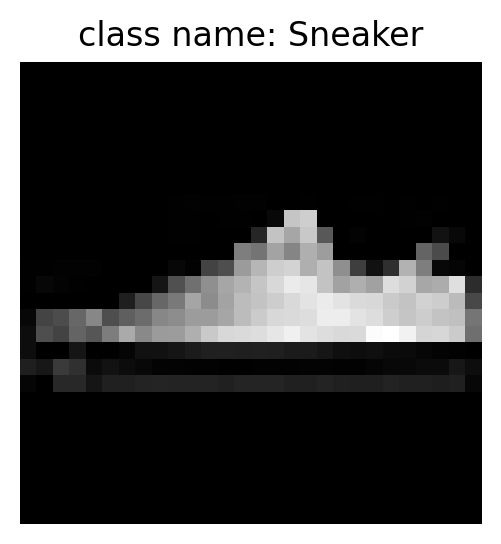

In [15]:
import numpy as np

image = x.squeeze()[0]
label = y[0].item()

image = (255 * image).numpy().astype(np.uint8)
class_name = class_names[label]

# построение изображения
plt.figure(figsize=(3, 3))
plt.imshow(image, cmap="gray")
plt.title(f"class name: {class_name}")
plt.axis("off");

In [18]:
class Net(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(28 * 28, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10),
        )

    def forward(self, x):
        # преобразуем размер 
        # B x 1 x 28 x 28 -> B x (28 * 28)
        x = x.view(-1, 28 * 28)
        
        y = self.layers(x)

        return y
    

class Classifier(pl.LightningModule):
    def __init__(self, hidden_size, learning_rate):
        super().__init__()
        self.save_hyperparameters()
        self.net = Net(hidden_size)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("train/loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("test_loss", loss)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch
        return self(x)

    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

model = Classifier(hidden_size=196, learning_rate=0.1)

In [19]:
import warnings
warnings.filterwarnings("ignore")

from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint


trainer = pl.Trainer(
    default_root_dir = DATA_DIR / "classifier",                          
    accelerator = "gpu" if torch.cuda.is_available() else "cpu",                    
    devices=1,                                                                         
    max_epochs=10,                                                                    
    callbacks=[
        #ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"), 
        LearningRateMonitor("epoch")
    ],                                     
    enable_progress_bar=True
)    


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


In [20]:
trainer.fit(model, datamodule=datamodule)


  | Name    | Type             | Params | Mode  | FLOPs
-------------------------------------------------------------
0 | net     | Net              | 155 K  | train | 0    
1 | loss_fn | CrossEntropyLoss | 0      | train | 0    
-------------------------------------------------------------
155 K     Trainable params
0         Non-trainable params
155 K     Total params
0.623     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
if colab:
    %tensorboard --logdir data/classifier/lightning_logs/version_0
else:
    !tensorboard --logdir data/classifier/lightning_logs/version_0

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms as T

import numpy as np

# 1. Define transformations: Convert images to PyTorch tensors
transform = T.Compose([
    T.ToTensor()
])
             
# 2. Load the Fashion-MNIST datasets (downloads if not present)
train_dataset = FashionMNIST(
    root=DATA_DIR, 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = FashionMNIST(
    root=DATA_DIR, 
    train=False, 
    download=True, 
    transform=transform
)


print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Посмотрим на один из сэмплов:

In [ ]:
# x - tensor
# y - int
x, y = train_dataset[2026]

class_name = class_names[y]

print(f"x.shape: {x.shape}")
print(f"label: {y}")
print(f"class name: {class_name}")

In [ ]:
import matplotlib.pyplot as plt

# де-нормализация изображения
image = (255 * x.squeeze()).numpy().astype(np.uint8)

# построение изображения
plt.figure(figsize=(3, 3))
plt.imshow(image, cmap="gray")
plt.title(f"class name: {class_name}")
plt.axis("off");

Создадим датасеты для обучения и тестирования:

In [ ]:
dataset = DataSet(DATA_DIR / "fashion-mnist/train")
test_dataset = DataSet(DATA_DIR / "fashion-mnist/test")

# число изображений в датасетах
print(f"dataset size: {len(dataset)}")
print(f"test_dataset size: {len(test_dataset)}")

Посмотрим на один из сэмплов:

In [ ]:
# x - numpy массив
# y - int
x, y = dataset[2026]

# имя класса
class_name = class_names[y]

print(f"x shape: {x.shape}")
print(f"y: {y}")

# де-нормализация изображения
image = (255 * x[0]).astype(np.uint8)

# построение изображения
plt.figure(figsize=(3, 3))
plt.imshow(image, cmap="gray")
plt.title(f"class: {class_name}")
plt.axis("off");

Разделим `dataset` на датасеты для обучения и валидации:

In [ ]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(
    dataset,
    [50_000, 10_000]
)

print(f"train_dataset size: {len(train_dataset)}")
print(f"val_dataset size: {len(val_dataset)}")

Создадим загрузчики батчей для обучения и валидации:

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,   # датасет
    batch_size=1024, # размер батча
    num_workers=0,   # число процессов для формирования батчей
    shuffle=True,    # перемешивать датасет в конце каждой эпохи
    drop_last=True   # выбрасывать последний неполный батч в эпохе
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1024,
    num_workers=0,
    shuffle=False,
    drop_last=False
)

# число батчей
print(f"train_loader size: {len(train_loader)}")
print(f"val_loader size: {len(val_loader)}")

Сгенерируем один батч из данных для обучения: 

In [ ]:
# для изображений размер батча должен
# иметь вид B x C x H x W
# (размер батча) x (число цветовых каналов) x (высота изображения) x (ширина изображения)

# выборка случайного батча данных из датасета
# x, y - это тензоры
x, y = next(iter(train_loader))

# приведение к нужному типу данных
x = x.float()
y = y.long()

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}\n")

print(f"x.min(): {x.min()}")
print(f"x.max(): {x.max()}")

#### **Модель классификатора**

Создадим полносвязную нейронную сеть для классификации с одним скрытым слоем:

In [ ]:
class Classifier(nn.Module):
    def __init__(self, D):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(28 * 28, D),
            nn.ReLU(),
            nn.Linear(D, 10),
        )

    def forward(self, x):
        # преобразуем размер 
        # B x 1 x 28 x 28 -> B x (28 * 28)
        x = x.view(-1, 28 * 28)
        
        y = self.layers(x)

        return y

Протестируем модель сети:

In [ ]:
model = Classifier(D=196)

x, y = next(iter(val_loader))

y_hat = model(x)

print(f"x shape: {x.shape}")
print(f"y_hat shape: {y_hat.shape}")

Выведем архитектуру модели:

In [ ]:
print(torchinfo.summary(model, input_size=x.shape, device="cpu"))

#### **Функция потерь и метрика**

Функция потерь для задачи мультиклассовой классификации - средняя кросс-энтропия на батче (Cross Entropy):
$$
    \mathbf{CE} = 
    -\frac{1}{|\mathcal{I}_t|}
    \sum_{i\in\mathcal{I}_t}\mathbf{p}_i\cdot\ln \widehat{\mathbf{p}}_i
$$
где $\mathbf{p}_i$ - one-hot вектор истинных вероятностей изображения с номером $i$:
$$
   \mathbf{p}_i = (0\,,0\,,\ldots\,,1\,,0\,,\ldots\,,0)
$$ 
$\widehat{\mathbf{p}}_i$ - вектор предсказанных моделью вероятностей изображения с номером $i$:
$$
    \widehat{\mathbf{p}}_i = \mathrm{softmax}[\widehat{\mathbf{y}}_i] = 
    \frac{\exp[\widehat{\mathbf{y}}_i]}{\sum\limits_j \exp[\widehat{y}_{ij}]}
$$

Загрузчик данных возвращает $\left\{\mathbf{y}_i\right\}_{i\in\mathcal{I}_t}$.

Модель возвращает $\left\{\widehat{\mathbf{y}}_i\right\}_{i\in\mathcal{I}_t}$.

Все необходимые преобразования в вероятности происходят в классе `torch.nn.CrossEntropyLoss()`:

In [ ]:
loss_fn = nn.CrossEntropyLoss()

x, y = next(iter(train_loader))

y_hat = model(x.float())

# вычисление loss функции по предсказанию `y_hat` и реальному `y`
# вычисления softmax и one-hot encoding `y` реализовано в `loss_fn` 
loss = loss_fn(y_hat, y)

print(f"loss value = {loss}")

В качестве оптимизатора возьмем SGD:

In [ ]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

В качестве метрики качества возьмем среднюю точность по классам:

In [ ]:
from torchmetrics.classification import MulticlassAccuracy

# вычисляет точность предсказания по каждому классу
metric = MulticlassAccuracy(num_classes=10, average=None)

Протестируем метрику качества:

In [ ]:
# итератор по данным
iterator = iter(val_loader)

# получим первый батч 
x, y = next(iterator)
y_hat = model(x.float())

# добавим в метрику
metric.update(y_hat, y.long())

# получим следующий батч
x, y = next(iterator)
y_hat = model(x.float())

# добавим в метрику
metric.update(y_hat, y.long())

# вычисление точности по каждому классу
accuracy = metric.compute()

# средняя точность по классам
mean_accuracy = accuracy.mean()

print(f"class accuracy: {accuracy}")
print(f"mean accuracy: {mean_accuracy}")

#### **Обучение модели**

Соберем все вместе и напишем полный цикл обучения и валидации модели по эпохам:

In [ ]:
from dataclasses import dataclass

from torchmetrics.aggregation import MeanMetric
from livelossplot import PlotLosses

from src.utils import set_seed

@dataclass
class Config:
    seed = 0xC0FFEE
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_workers = 0
    # гиперпараметры
    epochs = 10
    learning_rate = 0.1
    batch_size = 1000
    D = 196
    
cfg = Config()

# для воспроизводимости результатов обучения
set_seed(cfg.seed)

# загрузчик данных для обучения
train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=cfg.num_workers
)

# загрузчик данных для валидации
val_loader = DataLoader(
    val_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=cfg.num_workers
)

# модель классификатора
model = Classifier(D=cfg.D)
model = model.to(cfg.device)

# оптимизатор 
optimizer = torch.optim.SGD(params=model.parameters(), lr=cfg.learning_rate)

# функция потерь
loss_fn = nn.CrossEntropyLoss()

# для построения графиков во время обучения
plot = PlotLosses(figsize=(12, 3))

# лучшее значение метрики качества
best_metric = 0

for epoch in range(cfg.epochs):
    # ЭПОХА ОБУЧЕНИЯ МОДЕЛИ

    # модель переведем в режим обучения
    model.train()

    # значения loss функции на батчах одной эпохи
    batch_losses = torch.empty(0)

    metric = MulticlassAccuracy(num_classes=10, average=None)

    # для вычислений среднего значения метрики
    mean_metric = MeanMetric()

    # выбираем случайные батчи из обучающих данных
    for x, y in train_loader:
        x = x.float().to(cfg.device)
        y = y.long().to(cfg.device)

        # предсказание модели
        y_hat = model(x)

        # вычисление loss функции по предсказанию `y_hat` и реальному `y`
        loss = loss_fn(y_hat, y)

        # обнулим все производные перед их вычислениями
        # чтобы не было gradient accumulation
        optimizer.zero_grad()

        # вычисление производных loss функция по параметрам
        # c помощью метода обратного распространения ошибки (backpropagation)
        loss.backward()

        # обновление параметров модели
        optimizer.step()

        mean_metric.update(loss.detach().cpu())
        metric.update(y_hat.detach().cpu(), y.cpu())

    # среднее значение функции потерь в эпохе обучения
    train_epoch_loss = mean_metric.compute()
    
    # среднее значение метрики в эпохе обучения
    train_epoch_metric = metric.compute().mean()
    
    # ЭПОХА ВАЛИДАЦИИ МОДЕЛИ

    # модель переведем в режим валидации
    model.eval()

    batch_losses = torch.empty(0)

    metric = MulticlassAccuracy(num_classes=10, average=None)
    mean_metric = MeanMetric()

    for x, y in val_loader:
        x = x.float().to(cfg.device)
        y = y.long().to(cfg.device)

        # этот контекст рекомендуют использовать для ускорения вычислений при валидации
        with torch.no_grad():
            y_hat = model(x)
        
        loss = loss_fn(y_hat, y)

        mean_metric.update(loss.cpu())
        metric.update(y_hat.cpu(), y.cpu())

    # среднее значение функции потерь в эпохе валидации
    val_epoch_loss = mean_metric.compute()

    # среднее значение метрики в эпохе валидации
    val_epoch_metric = metric.compute().mean()

    # сохраняем модель, если на валидации метрика улучшилась
    if best_metric < val_epoch_metric:
        best_metric = val_epoch_metric
        torch.save(model.state_dict(), DATA_DIR / "classifier.pth")

    # построение графиков во время обучения
    plot.update({
        "loss": train_epoch_loss,
        "val_loss": val_epoch_loss,
        "accuracy": train_epoch_metric,
        "val_accuracy": val_epoch_metric
    })

    plot.send()

#### **Тестирование модели**

Загрузим веса обученной модели для тестирования:

In [ ]:
state_dict = torch.load(DATA_DIR / "classifier.pth", weights_only=True)

model = Classifier(cfg.D)
model.load_state_dict(state_dict, strict=True)

Протестируем на CPU модель на тестовых данных:

In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=1000,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

# модель в режим тестирования
model.eval()

metric = MulticlassAccuracy(num_classes=10, average=None)

# перебираем все батчи из тестовых данных
for x, y in test_loader:
    x = x.float()
    y = y.long()

    # при тестировании, для скорости
    # рекомендуют использовать `torch.inference_mode()` контекст
    with torch.inference_mode():
        y_hat = model(x)

    metric.update(y_hat, y)

class_accuracy = metric.compute()
mean_accuracy = class_accuracy.mean()

for label, accuracy in enumerate(class_accuracy):
    name = class_names[label]
    print(f"{name:>15}: {100 * accuracy.item():.2f} %")

print(f"\nmean_accuracy: {100 * mean_accuracy.item():.2f} %")



Возьмем одно тестовое изображение:

In [ ]:
x, y = test_dataset[102]

image = (255 * x[0]).astype(np.uint8)
name = class_names[y]

plt.figure(figsize=(3, 3))
plt.imshow(image, cmap="gray")
plt.title(f"Class: {name}")
plt.axis("off");

и сделаем на нем предсказание модели:

In [ ]:
# преобразование из 28 x 28 numpy array
# в 1 x 1 x 28 x 28 pytorch tensor
x = torch.from_numpy(image)
x = x.unsqueeze(0).unsqueeze(1)
x = x.float() / 255

with torch.inference_mode():
    y_hat = model(x)

# предсказанная метка класса - 
# это индекс максимального элемента выхода модели
pred_label = torch.argmax(y_hat, dim=1)

# преобразование из тензора в число
pred_label = pred_label.item()

# имя предсказанного класса
pred_class = class_names[pred_label]

print(f"Predicted class: {pred_class}")